# Bonus Chapter: Tracking the Coronavirus Pandemic

## Workflow

### _Prerequisite: Install Beautiful Soup_

For Windows: In the Conda Commandline (other OS, you guy's know it probably better no special commandline needed)  
` conda install beautifulsoup4`


### 1 ) Obtain a list of popular news sites. Consider using Feedsite, which maintains a list of the top 100 US news sites, and the top 100 world news sites.


#### _Like always Imports on top and function definitions_

In [1]:
from bs4 import BeautifulSoup

import re
import urllib
import urllib.parse as urlparse

import pandas as pd
import time

import geonamescache

from unidecode import unidecode 


from urllib.error import HTTPError
import unidecode

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from mpl_toolkits.basemap import Basemap

helper_colors = [
    'tab:red',
    'tab:orange',
    'tab:purple',
    'tab:pink',
    'tab:cyan',
    'tab:grey',
    'tab:olive',
    'tab:blue',
    'tab:green',
    'tab:brown',
]


##### Location search code from Chapter One and Two Mix of (Own and provide Solution) ##### Start #####
####### HACKY to Finish the Assignment "In-Time"
gc = geonamescache.GeonamesCache()
countries = [country["name"] for country in gc.get_countries().values()]
cities = [city['name'] for city in gc.get_cities().values()]

country_accent_mapping = {
        unidecode.unidecode(country): country for country in countries
}

city_accent_mapping = {
    unidecode.unidecode(city): city for city in cities
}

unaccented_cities = list(city_accent_mapping.keys())
unaccented_countries = set(country_accent_mapping.keys())

unaccented_cities = sorted(unaccented_cities, key=lambda x: len(x), reverse=True)
unaccented_countries = sorted(unaccented_countries, key=lambda x: len(x), reverse=True)


city_regex = r'\b|\b'.join(unaccented_cities)

country_regex = r"\b|\b".join(unaccented_countries)

####### HACKY to Finish the Assignment "In-Time"
_cities = gc.get_cities().items()

_countries = [ item for key, item in gc.get_countries_by_names().items()]


def get_country(name): 
    return [ item for item in _countries if not isinstance(name , float) and unidecode.unidecode(item.get("name")).lower() == unidecode.unidecode(name).lower()]

def get_cities_data(name):
    return [ value for key, value in _cities if not isinstance(name , float) and unidecode.unidecode(value.get("name")).lower() == unidecode.unidecode(name).lower()]

def get_city_high_population(city_items):
    maxPopulation = 0
    result = None
    for item in city_items:
        if maxPopulation < item.get("population"):
            result = item
            maxPopulation = item.get("population")
    return result
        

##### Location search code from Chapter One ##### End #####


def get_news_urls(url):
    """
    Gets all Urls to news sites from a feedspot.com page

    Parameters
    ----------
    url : str
        url of a specific feedspot.com page, that should be crawled
    
    Returns 
    -------
    list(str)
        a List with found the urls
    """
    news_urls = []
    page = urllib.request.urlopen(url)
    if page.getcode() == 200:
        html_document = BeautifulSoup(page)
        news_urls = [ extract_target_url(tag["href"]) for tag in html_document.body.select(".fsb .tlink")]
        
    return news_urls

def extract_target_url(url):
    """
    Get target news site url out of feedspot url

    Parameters
    ----------
    url : str
        url feepspot url
    
    Returns 
    -------
    str
        news site url
    """ 
    parsed = urlparse.urlparse(url)
    return urlparse.parse_qs(parsed.query)['q'][0].split(':',1)[1]

def get_page_type(html_document):
    """
    Basic page xml Structure checker

    Parameters
    ----------
    html_document : object
        bs4 object of the current page
    
    Returns 
    -------
    int
        type of page structure
        -1 unknown
        0 item  RSS  (I assume, didn't read the specs)
        1 entry Atom (I assume, didn't read the specs)
    """
    page_type = -1
    if html_document.find("entry"):
        page_type = 0
    elif html_document.find("item"):
        page_type = 1
    return page_type

def get_articles(url):
    """
    Gets all articles to from a feedspot.com page

    Parameters
    ----------
    url : str
        url for a specific News outlet
    
    Returns 
    -------
    list(Dict)
        a List with headline/Content Dictionary
    """
    articles = []
    try:
        page = urllib.request.urlopen(url)
        if page.getcode() == 200:
            html_document = BeautifulSoup(page)
        
            page_type = get_page_type(html_document)
            if page_type == 1 :
                articles = [{'headline':BeautifulSoup(tag1.text, "lxml").text,
                             'content': BeautifulSoup(tag2.text, "lxml").text} for tag1, tag2 in 
                               zip(html_document.findAll('title'), html_document.findAll('description'))]
            elif page_type == 0 :
                articles = [{'headline':BeautifulSoup(tag1.text, "lxml").text,
                             'content': BeautifulSoup(tag2.text, "lxml").text} for tag1, tag2 in 
                               zip(html_document.findAll('title'), html_document.findAll('content'))]
    except HTTPError as err:
        print('\tError')
        print('\t', err)
    except Exception as pika:
        print('\tError, PIKACHU')
        print('\t', pika)
        
    return articles


def get_location(article):
    """
    Get the biggest locatoion for the given article

    Parameters
    ----------
    article : Dict
        url for a specific News outlet
    
    Returns 
    -------
    Tuple
        Longitude / Latitude / CountryCode Dictionary
    """
    location = None
    clean_content = unidecode.unidecode(article['headline'] + ' ' + article['content'])
    
    
    city_match = re.search(city_regex, clean_content)
    country_match = re.search(country_regex, clean_content)
    cities = None if not city_match else city_match.group(0)
    countries = None if not country_match else country_match.group(0)
    
    if countries:
        best_country = get_country(countries)[0] 
        if 'capital' in best_country:
            
            max_city_location = get_city_high_population(get_cities_data(best_country['capital']))
            location = {
                'longitude' :max_city_location.get("longitude"),
                'latitude': max_city_location.get("latitude"),
                'countrycode':  max_city_location.get("countrycode")
            }
    elif cities:
        max_city_location = get_city_high_population(get_cities_data(cities))
        if max_city_location != None:
            location = {
                'longitude' :max_city_location.get("longitude"),
                'latitude': max_city_location.get("latitude"),
                'countrycode':  max_city_location.get("countrycode")
            }

    return location
    


#### Getting Urls for News Sites

In [2]:
feedspot_sites = ['https://blog.feedspot.com/world_news_blogs/','https://blog.feedspot.com/usa_news_websites/']

urls = []

for feedspot_site in feedspot_sites:
    urls += get_news_urls(feedspot_site) 
    
urls_count = len(urls)
print('Amount of Urls to crawl: ', urls_count)


Amount of Urls to crawl:  150


#### The individual news site URLs can be extracted from the Feedspot HTML. You simply need to leverage the Beautiful Soup library in order to parse out the necessary data.

This was done with the function `get_news_urls` in the last Section.

#### Crawl each news site. Identify articles that mention coronavirus or Covid-19 within the headline. Save the article headlines and article body texts on your local machine. Avoid including articles with duplicate titles.


**Don't forget to catch all the Errors**


In [3]:
articles = []

for idx,url in enumerate(urls):
    # print(f'{idx} of {urls_count}\n\tcurrent url: {url}') Debug message to see how long this takes
    articles += get_articles(url)
    
#  Filter only Covid headlines
key_words_regex_checker = 'Covid(-19)?|coronavirus'
articles = [article for article in articles if re.search(key_words_regex_checker,article['headline']) is not None]

# remove duplicates and save data
found_data_df = pd.DataFrame(articles).drop_duplicates("headline")
found_data_df.to_csv('bonus.csv')

found_data_df.head(10)


	Error
	 HTTP Error 403: Forbidden
	Error
	 HTTP Error 403: Forbidden
	Error
	 HTTP Error 404: Not Found
	Error
	 HTTP Error 404: Not Found
	Error
	 HTTP Error 403: Forbidden
	Error
	 HTTP Error 400: Bad Request: malformed Host header
	Error
	 HTTP Error 403: Forbidden
	Error
	 HTTP Error 403: Forbidden
	Error
	 HTTP Error 403: Forbidden
	Error
	 HTTP Error 403: Forbidden
	Error
	 HTTP Error 403: Forbidden
	Error
	 HTTP Error 403: Forbidden
	Error
	 HTTP Error 403: Forbidden
	Error
	 HTTP Error 403: Forbidden
	Error
	 HTTP Error 403: Forbidden
	Error
	 HTTP Error 403: Forbidden
	Error
	 HTTP Error 403: Forbidden
	Error
	 HTTP Error 403: Forbidden
	Error
	 HTTP Error 503: Service Unavailable
	Error
	 HTTP Error 403: Forbidden
	Error
	 HTTP Error 403: Forbidden
	Error
	 HTTP Error 403: Forbidden
	Error
	 HTTP Error 403: Forbidden
	Error
	 HTTP Error 403: Forbidden
	Error, PIKACHU
	 [WinError 10060] Ein Verbindungsversuch ist fehlgeschlagen, da die Gegenstelle nach einer bestimmten Zeitsp

,headline,content
0,Bill Gates calls Taiwan's handling of coronavi...,submitted by /u/New_Diet [link] [comments]
1,A zoo has been trying to get two pandas to mat...,submitted by /u/rromano125 [link] [comm...
2,The UK rejects Trump's offer to help with Bori...,submitted by /u/ManiaforBeatles [link] ...
3,UK thanks Cuba for 'great gesture of solidarit...,submitted by /u/Infjuk [link] [comments]
4,Sweden is facing increasing pressure to impose...,submitted by /u/EnoughPM2020 [link] [co...
5,Coronavirus: Doctors and nurses will need PTSD...,submitted by /u/pontoumporcento [link] ...
6,China outraged after Brazil minister suggests ...,submitted by /u/BattlemechJohnBrown [li...
7,51 recovered coronavirus patients test positiv...,submitted by /u/Snuffleupagus_Panda [li...
8,Paris bans daytime jogging in bid to slow spre...,submitted by /u/Heitao [link] [comments]
9,Russia ready to start testing coronavirus vacc...,The lockdown that served as a model for countr...


#### Extract the locations from each headline, as well as from the body of the text.

This is done a bit hacky using the code from the First and Second Chapter, a part of my own code and a apart from the solution. (To save time) SHOULD BE OPTIMIZED !!! OMG

In [4]:
 
found_data_df['location'] = found_data_df.apply(lambda row: get_location(row.to_dict()), axis=1)
found_data_df.to_csv('Bonus_loc.csv')

#### Cluster the locations, and visualize the clusters on the map.

Remove Headline without Location, and draw on the map.

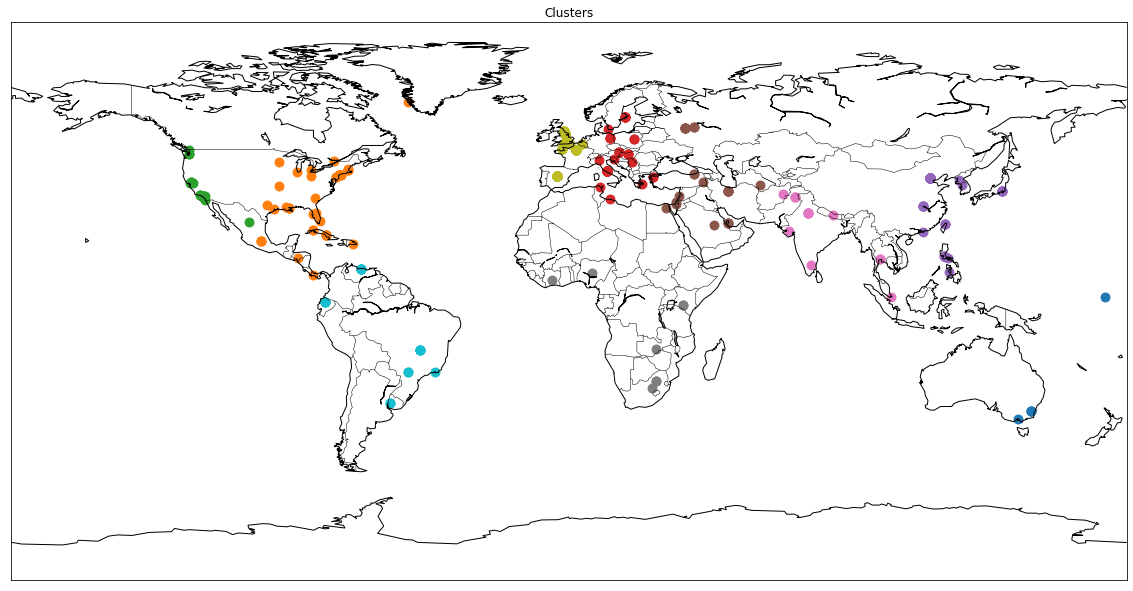

In [5]:

found_data_df = found_data_df.dropna( axis=0, how='any',  subset=["location"])

locations = [[row["location"]["latitude"], row["location"]["longitude"]] for key, row in found_data_df.iterrows() ]

map_plotter = Basemap()

k_values = range(1, 20)
inertia_values = [KMeans(k).fit(locations).inertia_ for k in k_values]

fig, ax1= plt.subplots(figsize=(20,12))

ax1.set_title('Clusters')

location_clusters = KMeans(10).fit_predict(locations)

colors = [helper_colors[cluster] for cluster in  location_clusters]

for i in range(len(locations)):
    color = colors[i]
    lat = locations[i][0]
    long = locations[i][1]

    map_plotter.scatter([long], [lat], color=color, latlon=True, s=80)
    
map_plotter.drawcoastlines()
map_plotter.drawcountries()
plt.show()

#### Consider incorporating the article publication dates to plot each cluster’s growth rate over time. These growth rates could potentially be used to measure the virus spread in certain locations.

_Well I will skip this, for now, since I this would mean reimporting extra fields_


#### Consider running a separate analysis on small clusters, as well as singleton locations that do not cluster with any other datapoint. *These isolated locations might represent future hot-spots in which an outbreak is just beginning.

_Well I will skip this, for now, since the time is up_

#### Write up your analysis in a blog post, and share that analysis with others.
_Well I will skip this, for now, since the time is up, and I have no blog_

## Conculsion: Bouns Chapter is a great practice, but I started way to late, so I will have to end this on my own. Thanks and Stay Save